In [13]:
import wfdb
import pywt
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers, regularizers

In [2]:
def generate_scalogram(signal, filename):
    scales = np.arange(1, 128)
    coef, _ = pywt.cwt(signal, scales, 'morl')
    plt.imshow(coef, cmap='jet', aspect='auto')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for 3+ classes
    subset='training'
)

val_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5200 images belonging to 5 classes.
Found 1300 images belonging to 5 classes.


In [49]:
model = tf.keras.Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(128, 128,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate= 0.3),

    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(32,activation='relu'),
    Dense(6,activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,396,774 (28.22 MB)

 Trainable params: 7,396,710 (28.22 MB)

 Non-trainable params: 64 (256.00 B)

In [16]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('ecg_model_custom-1_epochs-10.h5')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6361 - loss: 3.1799 - val_accuracy: 0.7831 - val_loss: 2.7040
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - accuracy: 0.8342 - loss: 1.9216 - val_accuracy: 0.8277 - val_loss: 1.8271
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8469 - loss: 1.4210 - val_accuracy: 0.7715 - val_loss: 1.3810
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8764 - loss: 1.0595 - val_accuracy: 0.8446 - val_loss: 0.9795
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8906 - loss: 0.8459 - val_accuracy: 0.8200 - val_loss: 0.8845
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8782 - loss: 0.7430 - val_accuracy: 0.8615 - val_loss: 0.7215
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9092 - loss: 0.5860 - val_accuracy: 0.8338 - val_loss: 0.6771
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9069 - loss: 0.5

In [19]:
loss, accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.8413 - loss: 0.5625
Test Accuracy: 82.62%


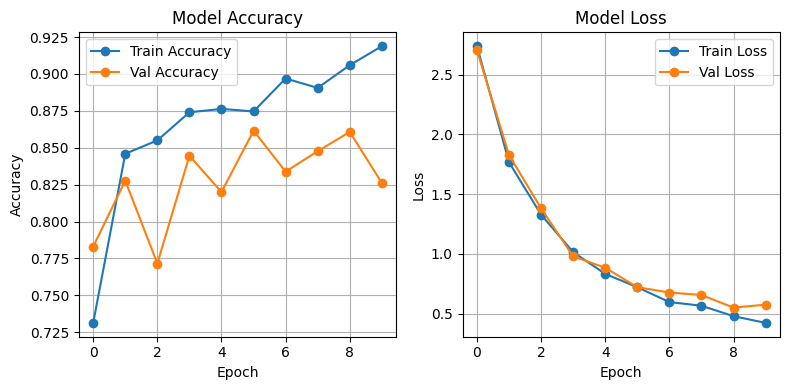

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_curves_for_ecg_mmodel.png')

In [21]:
def load_user_signal(folder_path, record_name='sample'):
    record = wfdb.rdrecord(f"{folder_path}/{record_name}")
    signal = record.p_signal[:, 0]  # First lead
    fs = record.fs
    return signal[:2*fs], fs  # First 2 seconds

In [22]:
print(train_gen.class_indices)

{'arrhythmia': 0, 'artial_shuffled': 1, 'malignant_shuffled': 2, 'normal': 3, 'st_shuffled': 4}


In [23]:
def predict_heart_condition(model_path, img_path):
    model = load_model(model_path)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]
    predicted_class = np.argmax(prediction)
    class_labels = ['arrhythmia','artial','malignant', 'normal', 'st-change']
    return class_labels[predicted_class]

In [24]:
signal, fs = load_user_signal('./user/normal','./16786')  # Assuming user_ecg.dat/.hea exists
generate_scalogram(signal, 'user_scalogram.png')
result = predict_heart_condition('ecg_model_custom-1_epochs-10.h5', 'user_scalogram.png')
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Prediction: normal


In [25]:
def complete_pipeline(folder_path, record_name, true_label):
    signal, fs = load_user_signal(folder_path, record_name)
    generate_scalogram(signal, 'user_scalogram.png')
    predicted_label = predict_heart_condition('ecg_model_custom-1_epochs-10.h5', 'user_scalogram.png')

    # Plot signal with predicted and true label in title
    time = np.linspace(0, 2, len(signal))  # 2 seconds
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='black')
    plt.title(f"Predicted: {predicted_label} | True: {true_label}", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Prediction:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


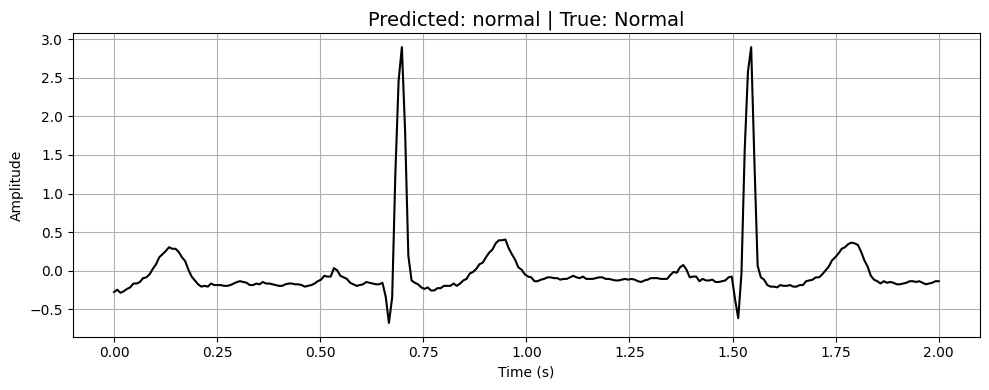

Prediction: normal


In [26]:
complete_pipeline('./user/normal','16786',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


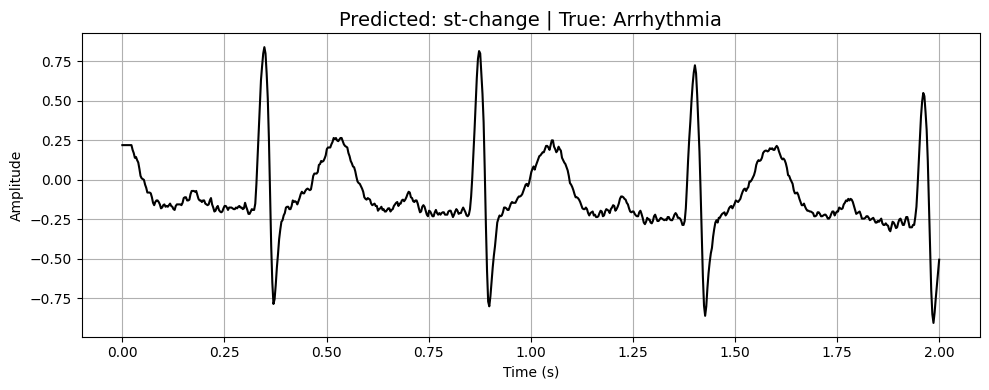

Prediction: st-change


In [27]:
complete_pipeline('./user/arrhy','215',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


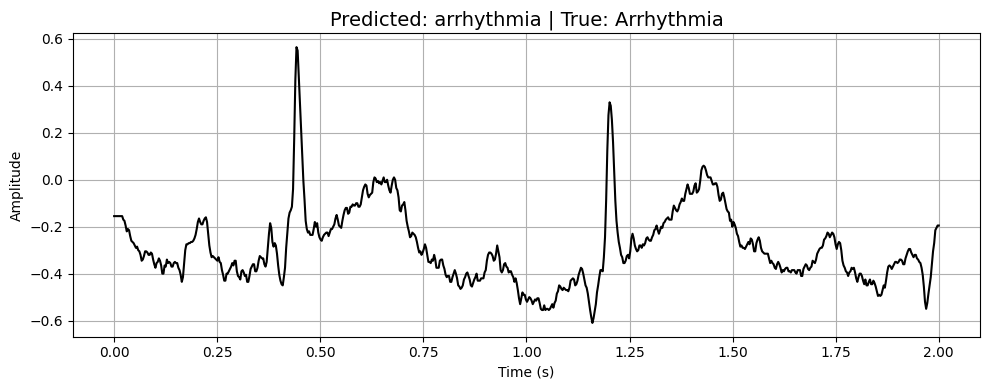

Prediction: arrhythmia


In [28]:
complete_pipeline('./user/arrhy','228',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


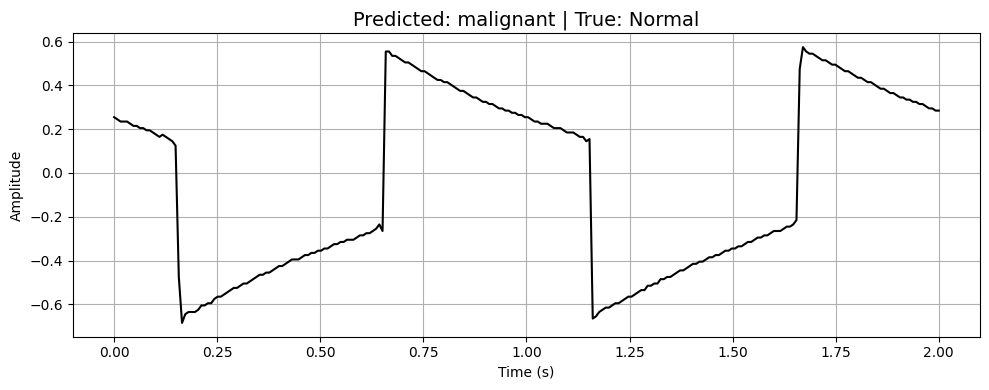

Prediction: malignant


In [29]:
complete_pipeline('./user/normal','19140',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


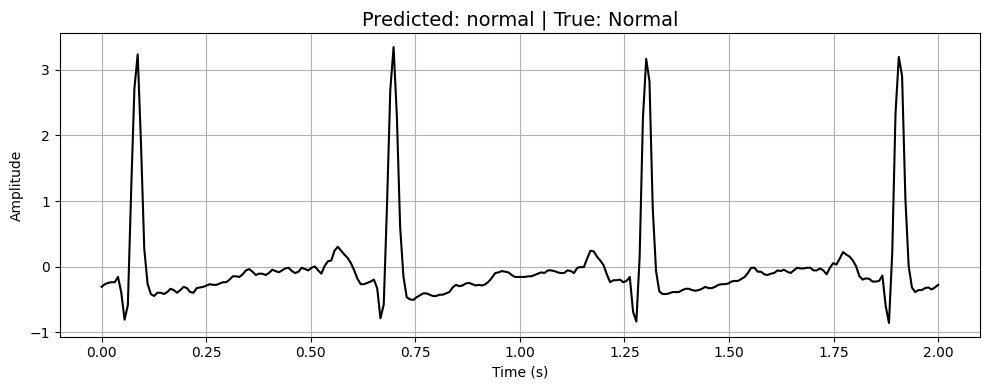

Prediction: normal


In [30]:
complete_pipeline('./user/normal','16273',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


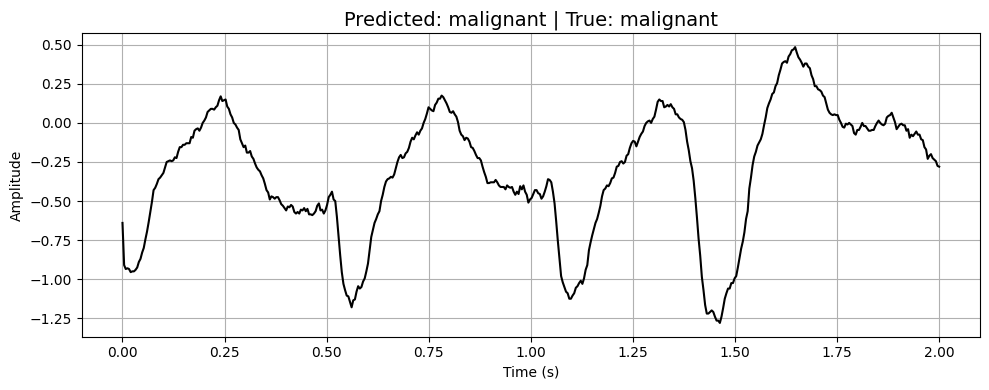

Prediction: malignant


In [31]:
complete_pipeline('./user/malignant/','418',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


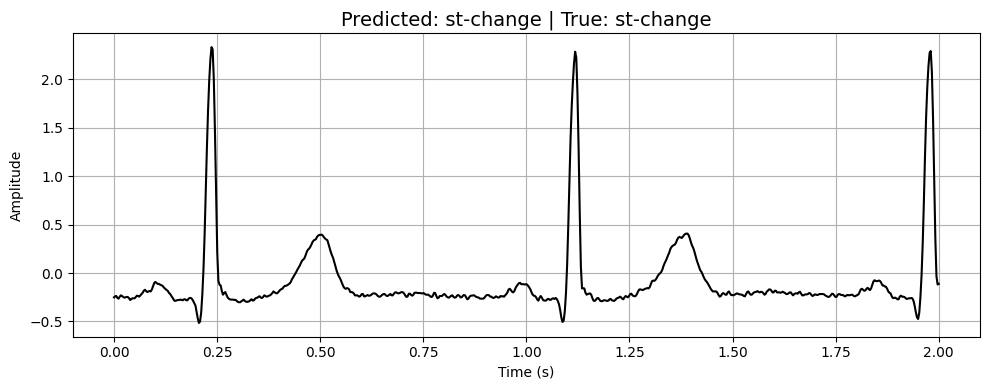

Prediction: st-change


In [32]:
complete_pipeline('./user/st/','313',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


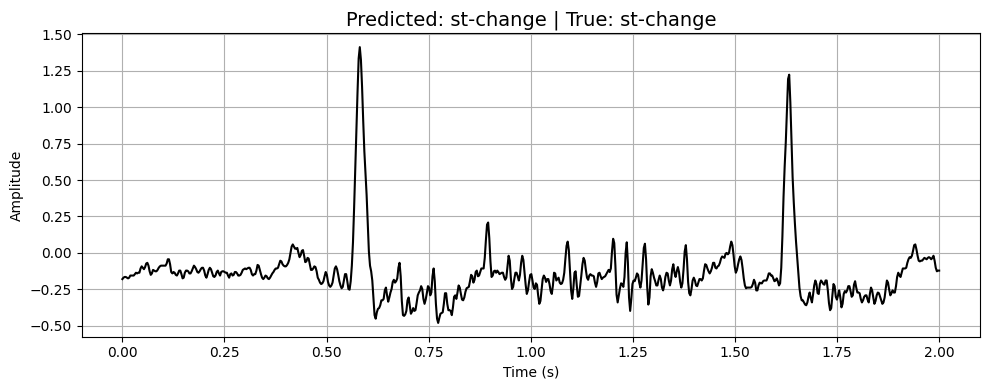

Prediction: st-change


In [33]:
complete_pipeline('./user/st/','314',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


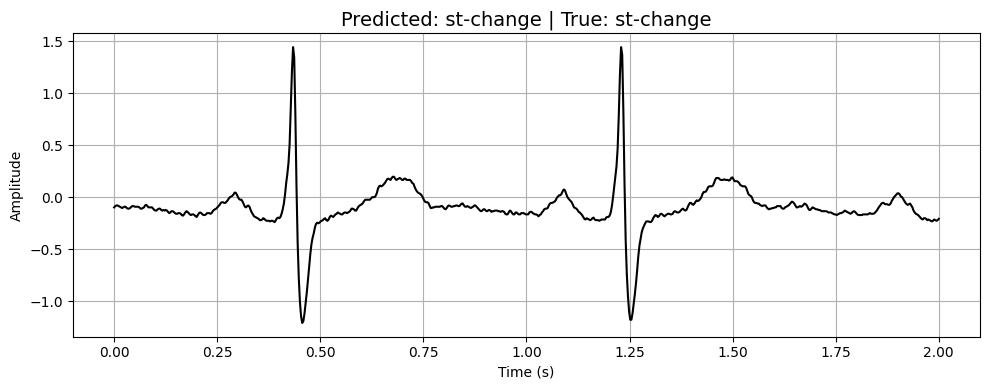

Prediction: st-change


In [34]:
complete_pipeline('./user/st/','321',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


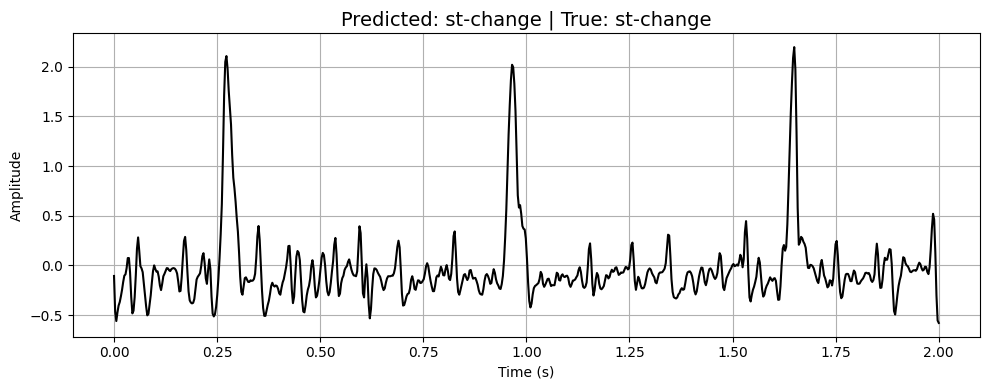

Prediction: st-change


In [35]:
complete_pipeline('./user/st/','322',true_label='st-change')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


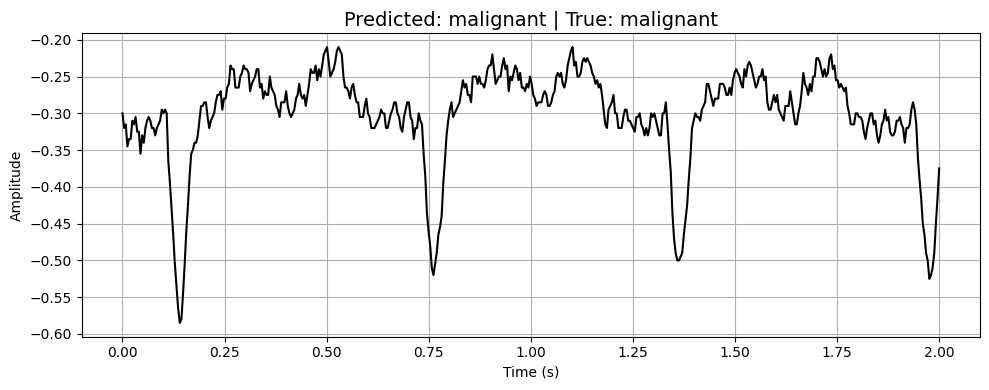

Prediction: malignant


In [36]:
complete_pipeline('./user/malignant/','429',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


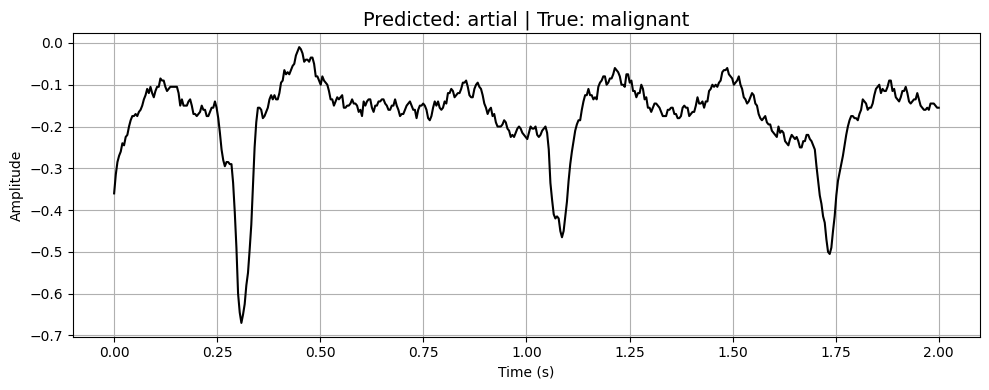

Prediction: artial


In [37]:
complete_pipeline('./user/malignant/','430',true_label='malignant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


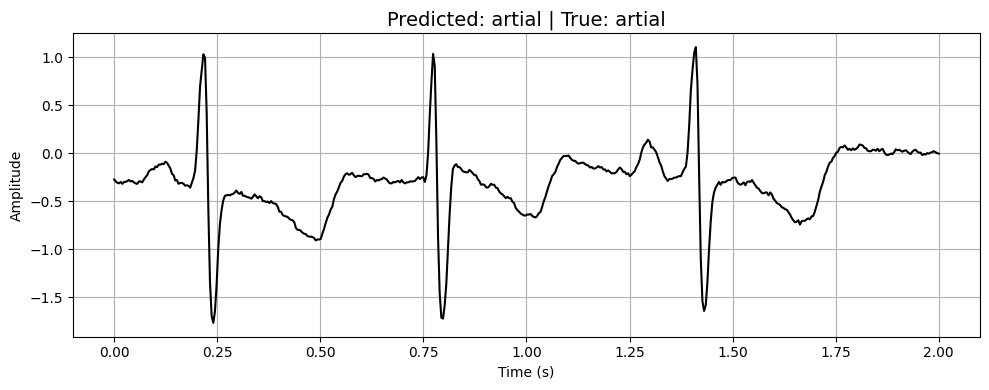

Prediction: artial


In [38]:
complete_pipeline('./user/artial/','04015',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


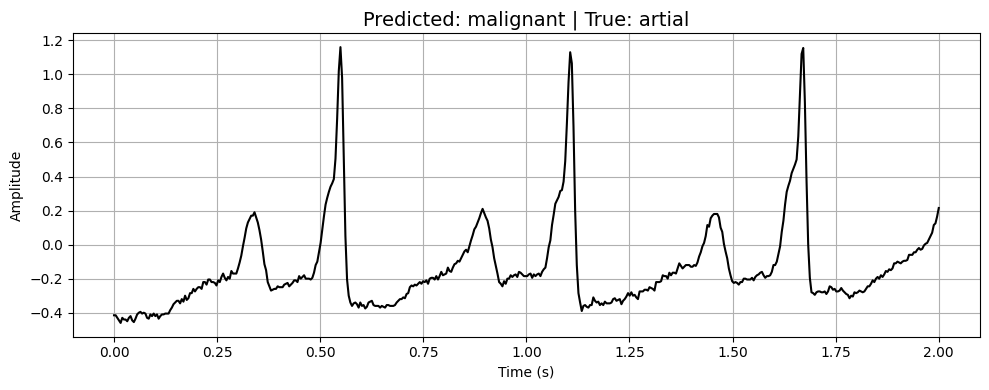

Prediction: malignant


In [39]:
complete_pipeline('./user/artial/','04043',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


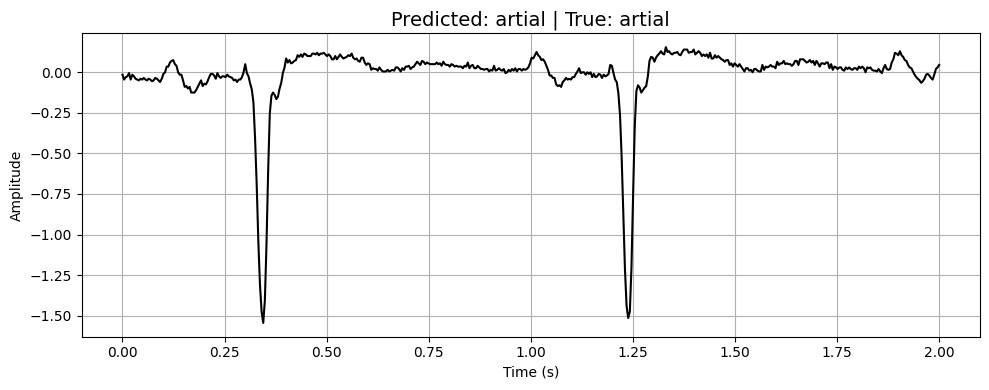

Prediction: artial


In [40]:
complete_pipeline('./user/artial/','04936',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


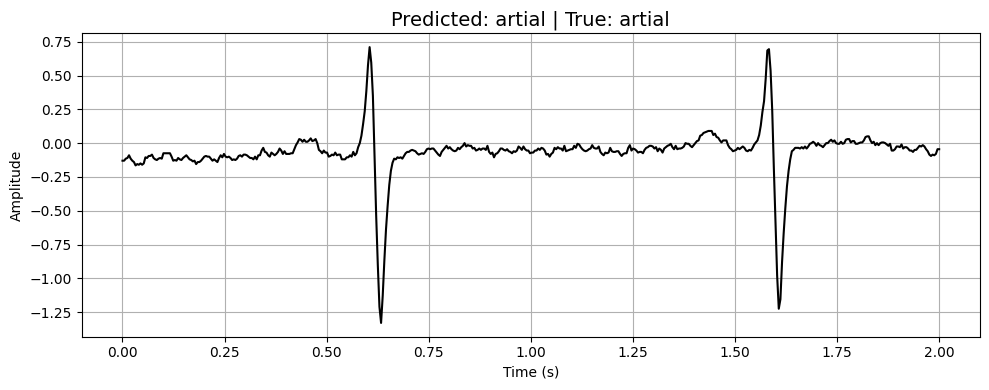

Prediction: artial


In [41]:
complete_pipeline('./user/artial/','05091',true_label='artial')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


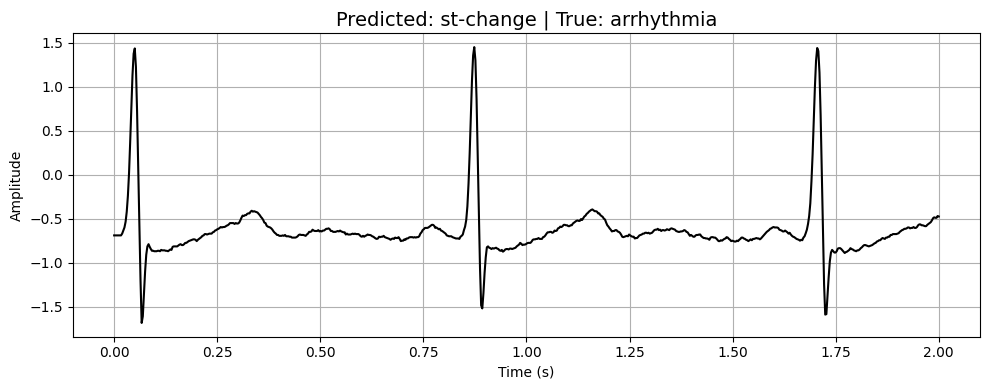

Prediction: st-change


In [42]:
complete_pipeline('./user/arrhy/','220',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


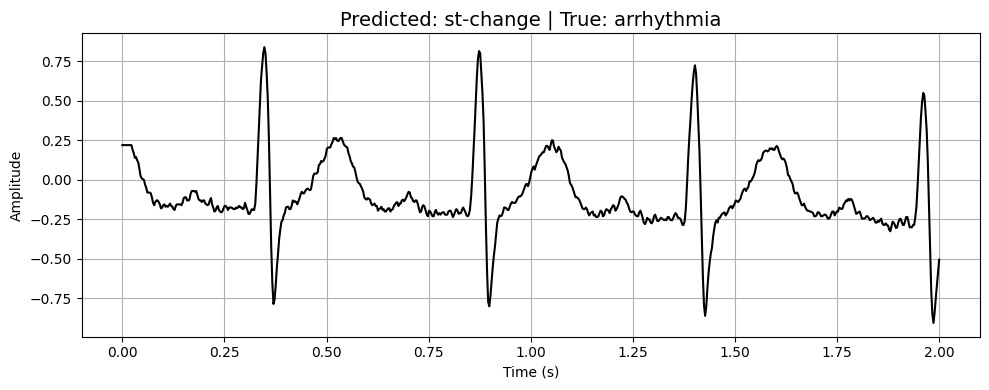

Prediction: st-change


In [43]:
complete_pipeline('./user/arrhy/','215',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


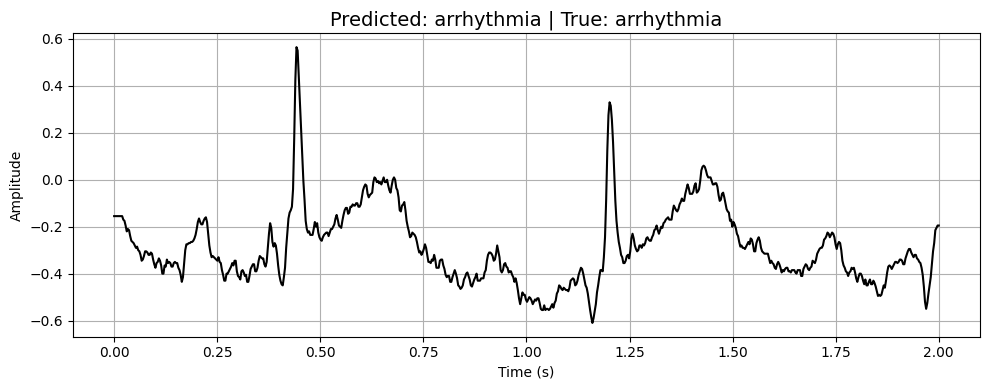

Prediction: arrhythmia


In [44]:
complete_pipeline('./user/arrhy/','228',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


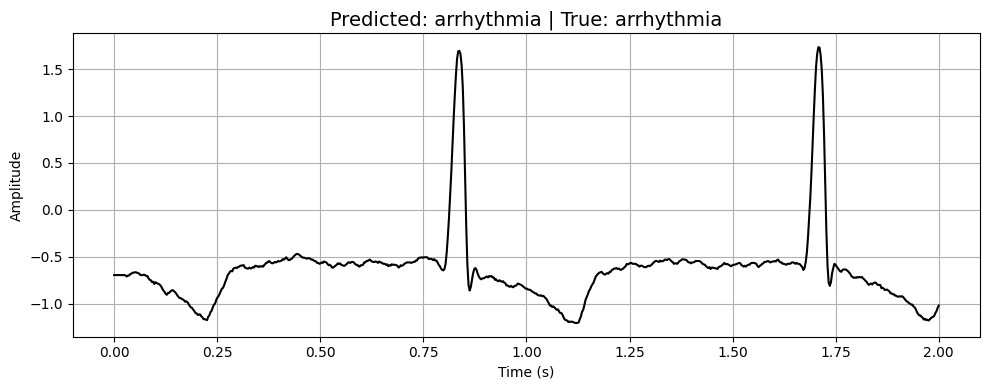

Prediction: arrhythmia


In [45]:
complete_pipeline('./user/arrhy/','219',true_label='arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


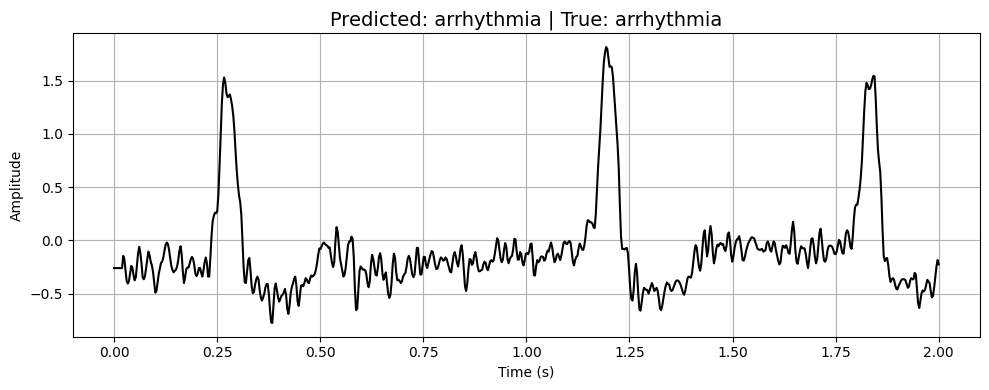

Prediction: arrhythmia


In [46]:
complete_pipeline('./user/arrhy/','203',true_label='arrhythmia')

In [51]:
model_2 = tf.keras.Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate= 0.3),
    
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(5,activation='softmax')
])

In [53]:
model_2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
history = model_2.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('ecg_model_custom-2_epochs-10.h5')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6515 - loss: 3.5041 - val_accuracy: 0.7292 - val_loss: 2.9953
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 734ms/step - accuracy: 0.7755 - loss: 2.2721 - val_accuracy: 0.6700 - val_loss: 2.1856
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 684ms/step - accuracy: 0.7964 - loss: 1.7655 - val_accuracy: 0.7608 - val_loss: 1.6123
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 744ms/step - accuracy: 0.8089 - loss: 1.4346 - val_accuracy: 0.8031 - val_loss: 1.3080
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 681ms/step - accuracy: 0.8207 - loss: 1.2229 - val_accuracy: 0.7885 - val_loss: 1.1856
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 821ms/step - accuracy: 0.8177 - loss: 1.0687 - val_accuracy: 0.8262 - val_loss: 0.9941
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 758ms/step - accuracy: 0.8195 - loss: 0.9441 - val_accuracy: 0.8238 - val_loss: 0.8799
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 820ms/step - accuracy: 0.8357 - lo

In [56]:
loss, accuracy = model_2.evaluate(val_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.8454 - loss: 0.7072
Test Accuracy: 83.77%


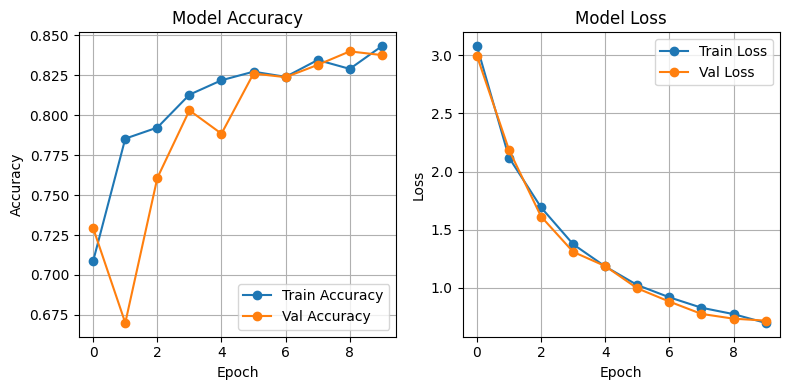

<Figure size 640x480 with 0 Axes>

In [57]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_curves_for_ecg_mmodel.png')